In [1]:
import torch,os
import torchvision.transforms as transforms
import torchvision.datasets as dset
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import matplotlib

c:\Users\prana\OneDrive\Desktop\IITHyderabad\codes\DL\Assign3\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 500

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
use_cuda = torch.cuda.is_available()
softmax=torch.nn.Softmax()

In [3]:
class VAE_conv(nn.Module):
        def __init__(self,x_channels=1,h_dim=2304,z_dim=2):
                super(VAE_conv, self).__init__()
                
                #encoder part
                self.encoder=nn.Sequential(
                        nn.Conv2d(x_channels,32,kernel_size=3,stride=2),
                        nn.ReLU(),
                        nn.Conv2d(32,64,kernel_size=3,stride=2),
                        nn.ReLU()
                )
                self.fc1=nn.Linear(h_dim,z_dim)
                self.fc2=nn.Linear(h_dim,z_dim)
                self.fc3=nn.Linear(z_dim,h_dim)
                #decoder part
                self.decoder=nn.Sequential(
                        nn.ConvTranspose2d(h_dim,64,kernel_size=4,stride=2),
                        nn.ReLU(),
                        nn.ConvTranspose2d(64,32,kernel_size=6,stride=2),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32,x_channels,kernel_size=6,stride=2)
                )

        def reparametrize(self,mu,logvar):
                std = logvar.mul(0.5).exp_()
                # return torch.normal(mu, std)
                esp = torch.randn(*mu.size())
                z = mu + std * esp
                return z
        
        def bottleneck(self,h):
                mu,logvar=self.fc1(h),self.fc2(h)
                z=self.reparametrize(mu,logvar)
                return z,mu,logvar
        
        def encode(self,X):
                temp=self.encoder(X)
                temp=torch.flatten(temp)
                z,mu,logvar=self.bottleneck(temp)
                return z,mu,logvar
        
                
        def decode(self,z):
                temp=self.fc3(z)
                temp=torch.reshape(temp,(2304,1,1))
                return self.decoder(temp)
        
        def forward(self,X):
                z,mu,logvar=self.encode(X)
                return self.decode(z),mu,logvar


In [4]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.mse_loss(recon_x.view(784), x.view(784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [5]:
model=VAE_conv()
max_epochs=50
learning_rate=0.1
optimizer = torch.optim.Adam(model.parameters())
for epoch in range(max_epochs):
    for pts in range(train_loader.batch_size):
        optimizer.zero_grad()
        x=train_loader.dataset[pts][0]
        recon_x,mu,log_var=model.forward(x)
        loss=loss_function(recon_x,x,mu,log_var)
        loss.backward()
        optimizer.step()
    print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


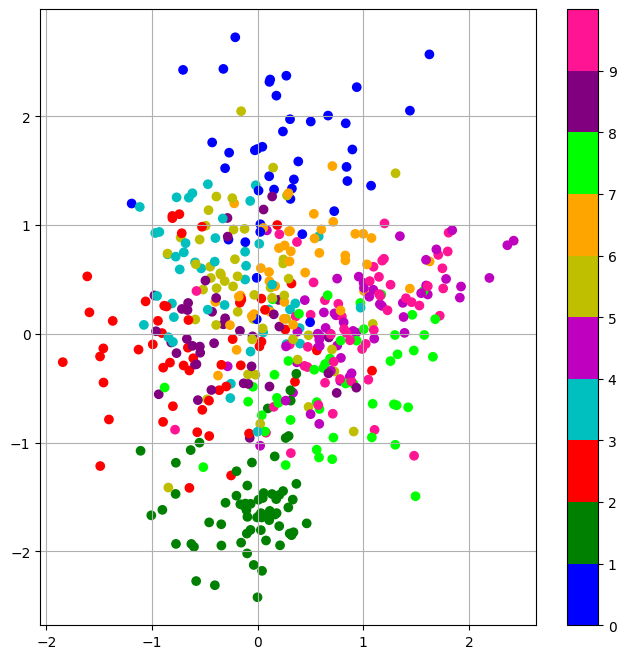

In [6]:
encoded_x=[]
for i in range(test_loader.batch_size):
    encoded_x.append(model.encode(test_loader.dataset[i][0])[0].detach().numpy())
encoded_x=np.array(encoded_x)
colors=['b','g','r','c','m','y','orange','lime','purple','deeppink']
x=encoded_x[:,0]
y=encoded_x[:,1]
labels=[]
classes=[0,1,2,3,4,5,6,7,8,9]
for i in range(test_loader.batch_size):
    labels.append(test_loader.dataset[i][1])
fig = plt.figure(figsize=(8,8))
plt.scatter(x, y, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
plt.grid()
loc = np.arange(0,max(labels),max(labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(classes)

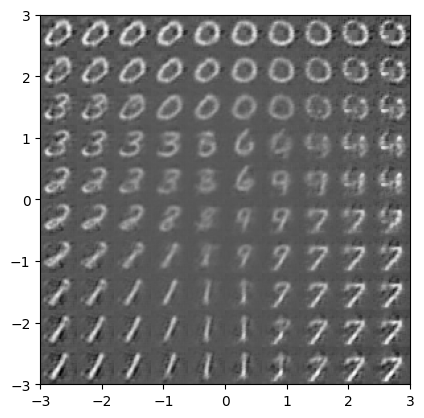

In [7]:
r0=(-3,3)
r1=(-3, 3) 
w = 28
n=10
img = np.zeros((n*w, n*w))
for i, y in enumerate(np.linspace(*r1, n)):
    for j, x in enumerate(np.linspace(*r0, n)):
        z = torch.Tensor([[x, y]])
        x_hat=model.decode(z).detach().numpy()
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
plt.imshow(img, extent=[*r0, *r1],cmap='Greys_r')